In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import detrend

# Load CSV file
def load_data(filename):
    """
    Load voltage vs. time data from a CSV file.
    Assumes the file has columns: Time (s), Channel 1 (V), Channel 2 (V).
    """
    try:
        # Load the CSV with proper header handling
        data = pd.read_csv(filename, skiprows=18)  # First row is the header
        data.columns = data.columns.str.strip()  # Clean up column names

        # Extract relevant columns
        time = data["Time (s)"]
        channel1 = data["Channel 1 (V)"]
        channel2 = data["Channel 2 (V)"]

        return time, channel1, channel2

    except pd.errors.ParserError as e:
        print(f"ParserError: {e}")
        raise
    except KeyError as e:
        print(f"KeyError: {e}. Check column names in the CSV file.")
        raise

In [264]:
# calculate the RMS voltage
def calculate_rms(voltage):
    return np.sqrt(np.mean(np.square(voltage)))

def calc_snr(signal, noise):
    signal_rms = calculate_rms(signal)
    noise_rms = calculate_rms(noise)

    return 10 * np.log10(signal_rms / noise_rms)


In [290]:
def calc_peak_freq(raw_signal_arr, sampling_rate):
    # Perform FFT
    fftOutputSignal = np.fft.fft(raw_signal_arr)
    
    # Compute the corresponding frequency bins
    freqs = np.fft.fftfreq(len(fftOutputSignal), 1 / sampling_rate)
    
    # Take the magnitude of the FFT output (ignore complex part)
    magnitude = np.abs(fftOutputSignal)
    
    # Take the first half of the spectrum (positive frequencies)
    half_len = len(freqs) // 2
    magnitude = magnitude[:half_len]
    freqs = freqs[:half_len]

    # Find the peak frequency
    peak_freq = freqs[np.argmax(magnitude)]
    
    return magnitude, freqs, peak_freq



    

In [206]:

from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


In [324]:
# process the csv data 
def process_data(filename, signal_start, signal_end, bandwidth, led_freq, sampling_rate):
    """
    - filename: path to the csv file 
    - signal_start, signal_end: time range for signal
    - noise_start, noise_end: time range for noise
    """
    
    time, channel1, channel2 = load_data(filename)

    photodiode_signal = channel2[(time >= signal_start) & (time <= signal_end)] # that's on channel 2 of the scope


    # Plot data
    signal_no_dc = detrend(photodiode_signal)
    fftResult, freqs, peak_freq = calc_peak_freq(signal_no_dc, sampling_rate)


    print(f"Max FFT Amplitude: {np.max(fftResult)}")
    # print(f"Peak Frequency Index: {np.argmax(fftResult)}")
    print(f"Peak Frequency (Hz): {peak_freq}")

    print(f"Sampling Frequency: {sampling_rate}")
    print(f"Signal Length: {len(signal_no_dc)}")

    plt.plot(freqs, fftResult)
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

    w = (led_freq * 7)/ (sampling_rate / 2) # Normalize the frequency
    b, a = butter(5, w, 'low')
    filtered_signal = filtfilt(b, a, signal_no_dc)

    # Noise can be estimated by subtracting the filtered signal
    noise = signal_no_dc - filtered_signal
    print(f"Noise variance: {np.var(noise)}")
    print(f"Filtered Signal Min: {np.min(filtered_signal)}, Max: {np.max(filtered_signal)}")
    print(f"Noise Min: {np.min(noise)}, Max: {np.max(noise)}")

    # assert 0 < lowcut < sampling_rate/2 and 0 < highcut < sampling_rate/2, "Cutoff frequencies must be valid."

    # Filter the photodiode signal
    #filtered_signal = bandpass_filter(photodiode_signal, lowcut, highcut, sampling_rate)

    snr = calc_snr(filtered_signal, noise)

    print(f"SNR value: {snr:.2f}")

    plt.figure(figsize=(8,4))
    plt.plot(time, photodiode_signal, label='Original Signal')
    plt.plot(time, filtered_signal, label='Filtered Signal')
    plt.plot(time, noise, label='Noise')
    plt.legend()
    plt.ylabel("Voltage Amplitude (V)")
    plt.xlabel("Time (s)")
    plt.show()

    def psd_plot(photodiode_signal, fs):

        # Compute PSD using Welch's method
        frequencies, psd = welch(photodiode_signal, fs, nperseg=len(signal_no_dc)//2)

        # Plot the PSD
        plt.figure(figsize=(8, 4))
        plt.semilogy(frequencies, psd)  # semilogy for better visualization
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power Spectral Density (V²/Hz)")
        plt.title("Power Spectral Density (PSD) of Signal")
        plt.grid()
        plt.show()
    
    psd_plot(signal_no_dc, sampling_rate)


    return snr

In [328]:
# process the data 
import os

data_directory = "/Users/mac/Desktop/Capstone/2465-Underwater-LiFi/testData/"
signal_start = 0.99
signal_end = 1.1
noise_start = 0.99
noise_end = 1.1
sampling_freq = 5e7 # corrected from the csv file
bandwidth = 7000

# # process data 
# # Iterate over files in directory
# for name in os.listdir(data_directory):
#     # Open file
#     with open(os.path.join(data_directory, name)) as f:
#         print(f"Processing file '{name}'")
#         snr = process_data(os.path.join(data_directory, name), signal_start, signal_end, bandwidth, freqs[idx], sampling_freq)
#         snr_arr.append(snr)
#         idx += 1


Processing file '/Users/mac/Desktop/Capstone/2465-Underwater-LiFi/testData/10kHz0_5cm_LED1.csv'
Max FFT Amplitude: 8141.820060426846
Peak Frequency (Hz): 9155.2734375
Sampling Frequency: 50000000.0
Signal Length: 32768


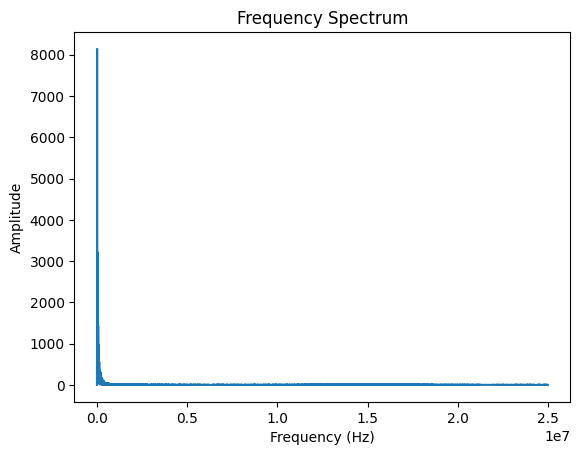

Noise variance: 0.0068194032848354225
Filtered Signal Min: -0.6661326279455493, Max: 0.6251921041075347
Noise Min: -0.573779167209284, Max: 0.5214089925733059
SNR value: 8.12


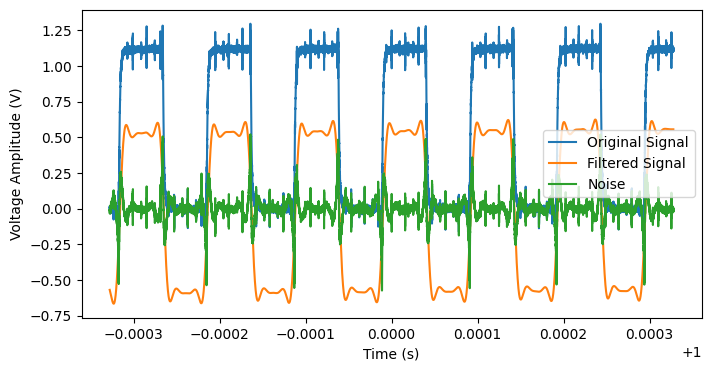

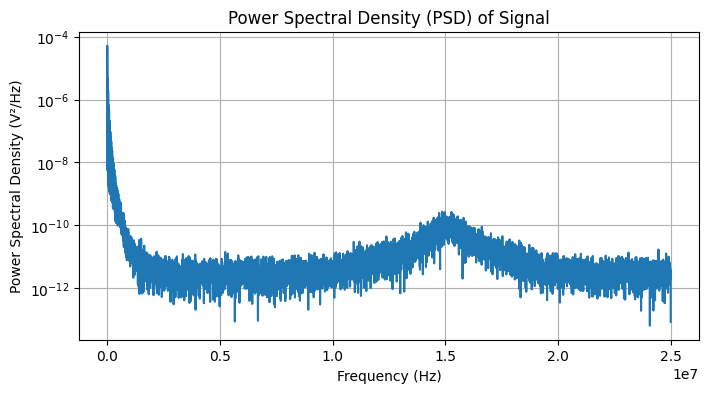

In [330]:

# Iterate over files in directory
# for name in os.listdir(data_directory):
#     # Open file
#     with open(os.path.join(data_directory, name)) as f:

file = "/Users/mac/Desktop/Capstone/2465-Underwater-LiFi/testData/10kHz0_5cm_LED1.csv"
print(f"Processing file '{file}'")
snr = process_data(file, signal_start, signal_end, bandwidth, 1e4, sampling_freq)

